In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, classification_report
from astropy.table import Table
from sklearn.metrics import roc_auc_score

df = pd.read_csv('student-data.csv')
dfv = pd.read_csv('student-data.csv')

In [2]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,no
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,yes
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,no
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,yes


In [3]:
# mapping strings to numeric values:
def numerical_data():
    df['school'] = df['school'].map({'GP': 0, 'MS': 1})
    df['sex'] = df['sex'].map({'M': 0, 'F': 1})
    df['address'] = df['address'].map({'U': 0, 'R': 1})
    df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})
    df['Pstatus'] = df['Pstatus'].map({'T': 0, 'A': 1})
    df['Mjob'] = df['Mjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['Fjob'] = df['Fjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['reason'] = df['reason'].map({'home': 0, 'reputation': 1, 'course': 2, 'other': 3})
    df['guardian'] = df['guardian'].map({'mother': 0, 'father': 1, 'other': 2})
    df['schoolsup'] = df['schoolsup'].map({'no': 0, 'yes': 1})
    df['famsup'] = df['famsup'].map({'no': 0, 'yes': 1})
    df['paid'] = df['paid'].map({'no': 0, 'yes': 1})
    df['activities'] = df['activities'].map({'no': 0, 'yes': 1})
    df['nursery'] = df['nursery'].map({'no': 0, 'yes': 1})
    df['higher'] = df['higher'].map({'no': 0, 'yes': 1})
    df['internet'] = df['internet'].map({'no': 0, 'yes': 1})
    df['romantic'] = df['romantic'].map({'no': 0, 'yes' : 1})
    df['passed'] = df['passed'].map({'no': 0, 'yes': 1})
    # reorder dataframe columns :
    col = df['passed']
    del df['passed']
    df['passed'] = col

    
# feature scaling will allow the algorithm to converge faster, large data will have same scal
def feature_scaling(df):
    for i in df:
        col = df[i]
        # let's choose columns that have large values
        if(np.max(col)>6):
            Max = max(col)
            Min = min(col)
            mean = np.mean(col)
            col  = (col-mean)/(Max)
            df[i] = col
        elif(np.max(col)<6):
            col = (col-np.min(col))
            col /= np.max(col)
            df[i] = col

In [4]:
numerical_data()
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0,1,18,0,1,1,4,4,3,0,...,0,0,4,3,4,1,1,3,6,0
1,0,1,17,0,1,0,1,1,3,4,...,1,0,5,3,3,1,1,3,4,0
2,0,1,15,0,0,0,1,1,3,4,...,1,0,4,3,2,2,3,3,10,1
3,0,1,15,0,1,0,4,2,1,2,...,1,1,3,2,2,1,1,5,2,1
4,0,1,16,0,1,0,3,3,4,4,...,0,0,4,3,2,1,2,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,0,20,0,0,1,2,2,2,2,...,0,0,5,5,4,4,5,4,11,0
391,1,0,17,0,0,0,3,1,2,2,...,1,0,2,4,5,3,4,2,3,1
392,1,0,21,1,1,0,1,1,4,4,...,0,0,5,5,3,3,3,3,3,0
393,1,0,18,1,0,0,3,2,2,4,...,1,0,4,4,1,3,4,5,0,1


In [5]:
feature_scaling(df)

df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0.0,1.0,0.059264,0.0,1.0,1.0,1.00,1.00,0.75,0.00,...,0.0,0.0,0.75,0.50,0.75,0.00,0.00,0.50,0.003882,0.0
1,0.0,1.0,0.013809,0.0,1.0,0.0,0.25,0.25,0.75,1.00,...,1.0,0.0,1.00,0.50,0.50,0.00,0.00,0.50,-0.022785,0.0
2,0.0,1.0,-0.077100,0.0,0.0,0.0,0.25,0.25,0.75,1.00,...,1.0,0.0,0.75,0.50,0.25,0.25,0.50,0.50,0.057215,1.0
3,0.0,1.0,-0.077100,0.0,1.0,0.0,1.00,0.50,0.25,0.50,...,1.0,1.0,0.50,0.25,0.25,0.00,0.00,1.00,-0.049451,1.0
4,0.0,1.0,-0.031646,0.0,1.0,0.0,0.75,0.75,1.00,1.00,...,0.0,0.0,0.75,0.50,0.25,0.00,0.25,1.00,-0.022785,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1.0,0.0,0.150173,0.0,0.0,1.0,0.50,0.50,0.50,0.50,...,0.0,0.0,1.00,1.00,0.75,0.75,1.00,0.75,0.070549,0.0
391,1.0,0.0,0.013809,0.0,0.0,0.0,0.75,0.25,0.50,0.50,...,1.0,0.0,0.25,0.75,1.00,0.50,0.75,0.25,-0.036118,1.0
392,1.0,0.0,0.195627,1.0,1.0,0.0,0.25,0.25,1.00,1.00,...,0.0,0.0,1.00,1.00,0.50,0.50,0.50,0.50,-0.036118,0.0
393,1.0,0.0,0.059264,1.0,0.0,0.0,0.75,0.50,0.50,1.00,...,1.0,0.0,0.75,0.75,0.00,0.50,0.75,1.00,-0.076118,1.0


In [6]:
df.shape

(395, 31)

In [7]:
df.dropna().shape

(395, 31)

In [8]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed'],
      dtype='object')

In [9]:
features=['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences']

In [10]:
dfv['passed'].value_counts()

yes    265
no     130
Name: passed, dtype: int64

In [11]:
X=df[features]
target_variable='passed'
y=df[target_variable]

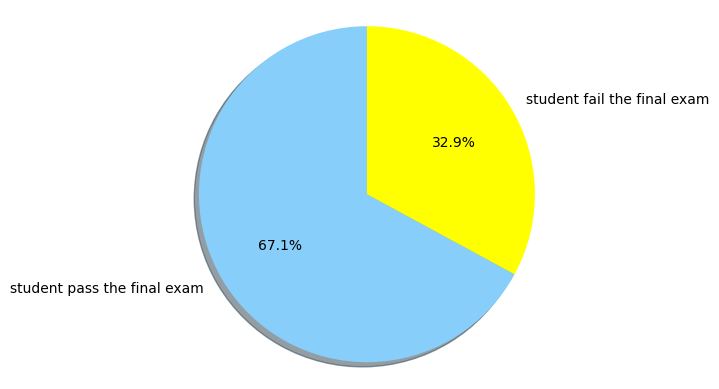

In [12]:
labels = 'student pass the final exam ', 'student fail the final exam'
sizes = [265, 130]
colors=['lightskyblue','yellow']
fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',colors=colors,
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

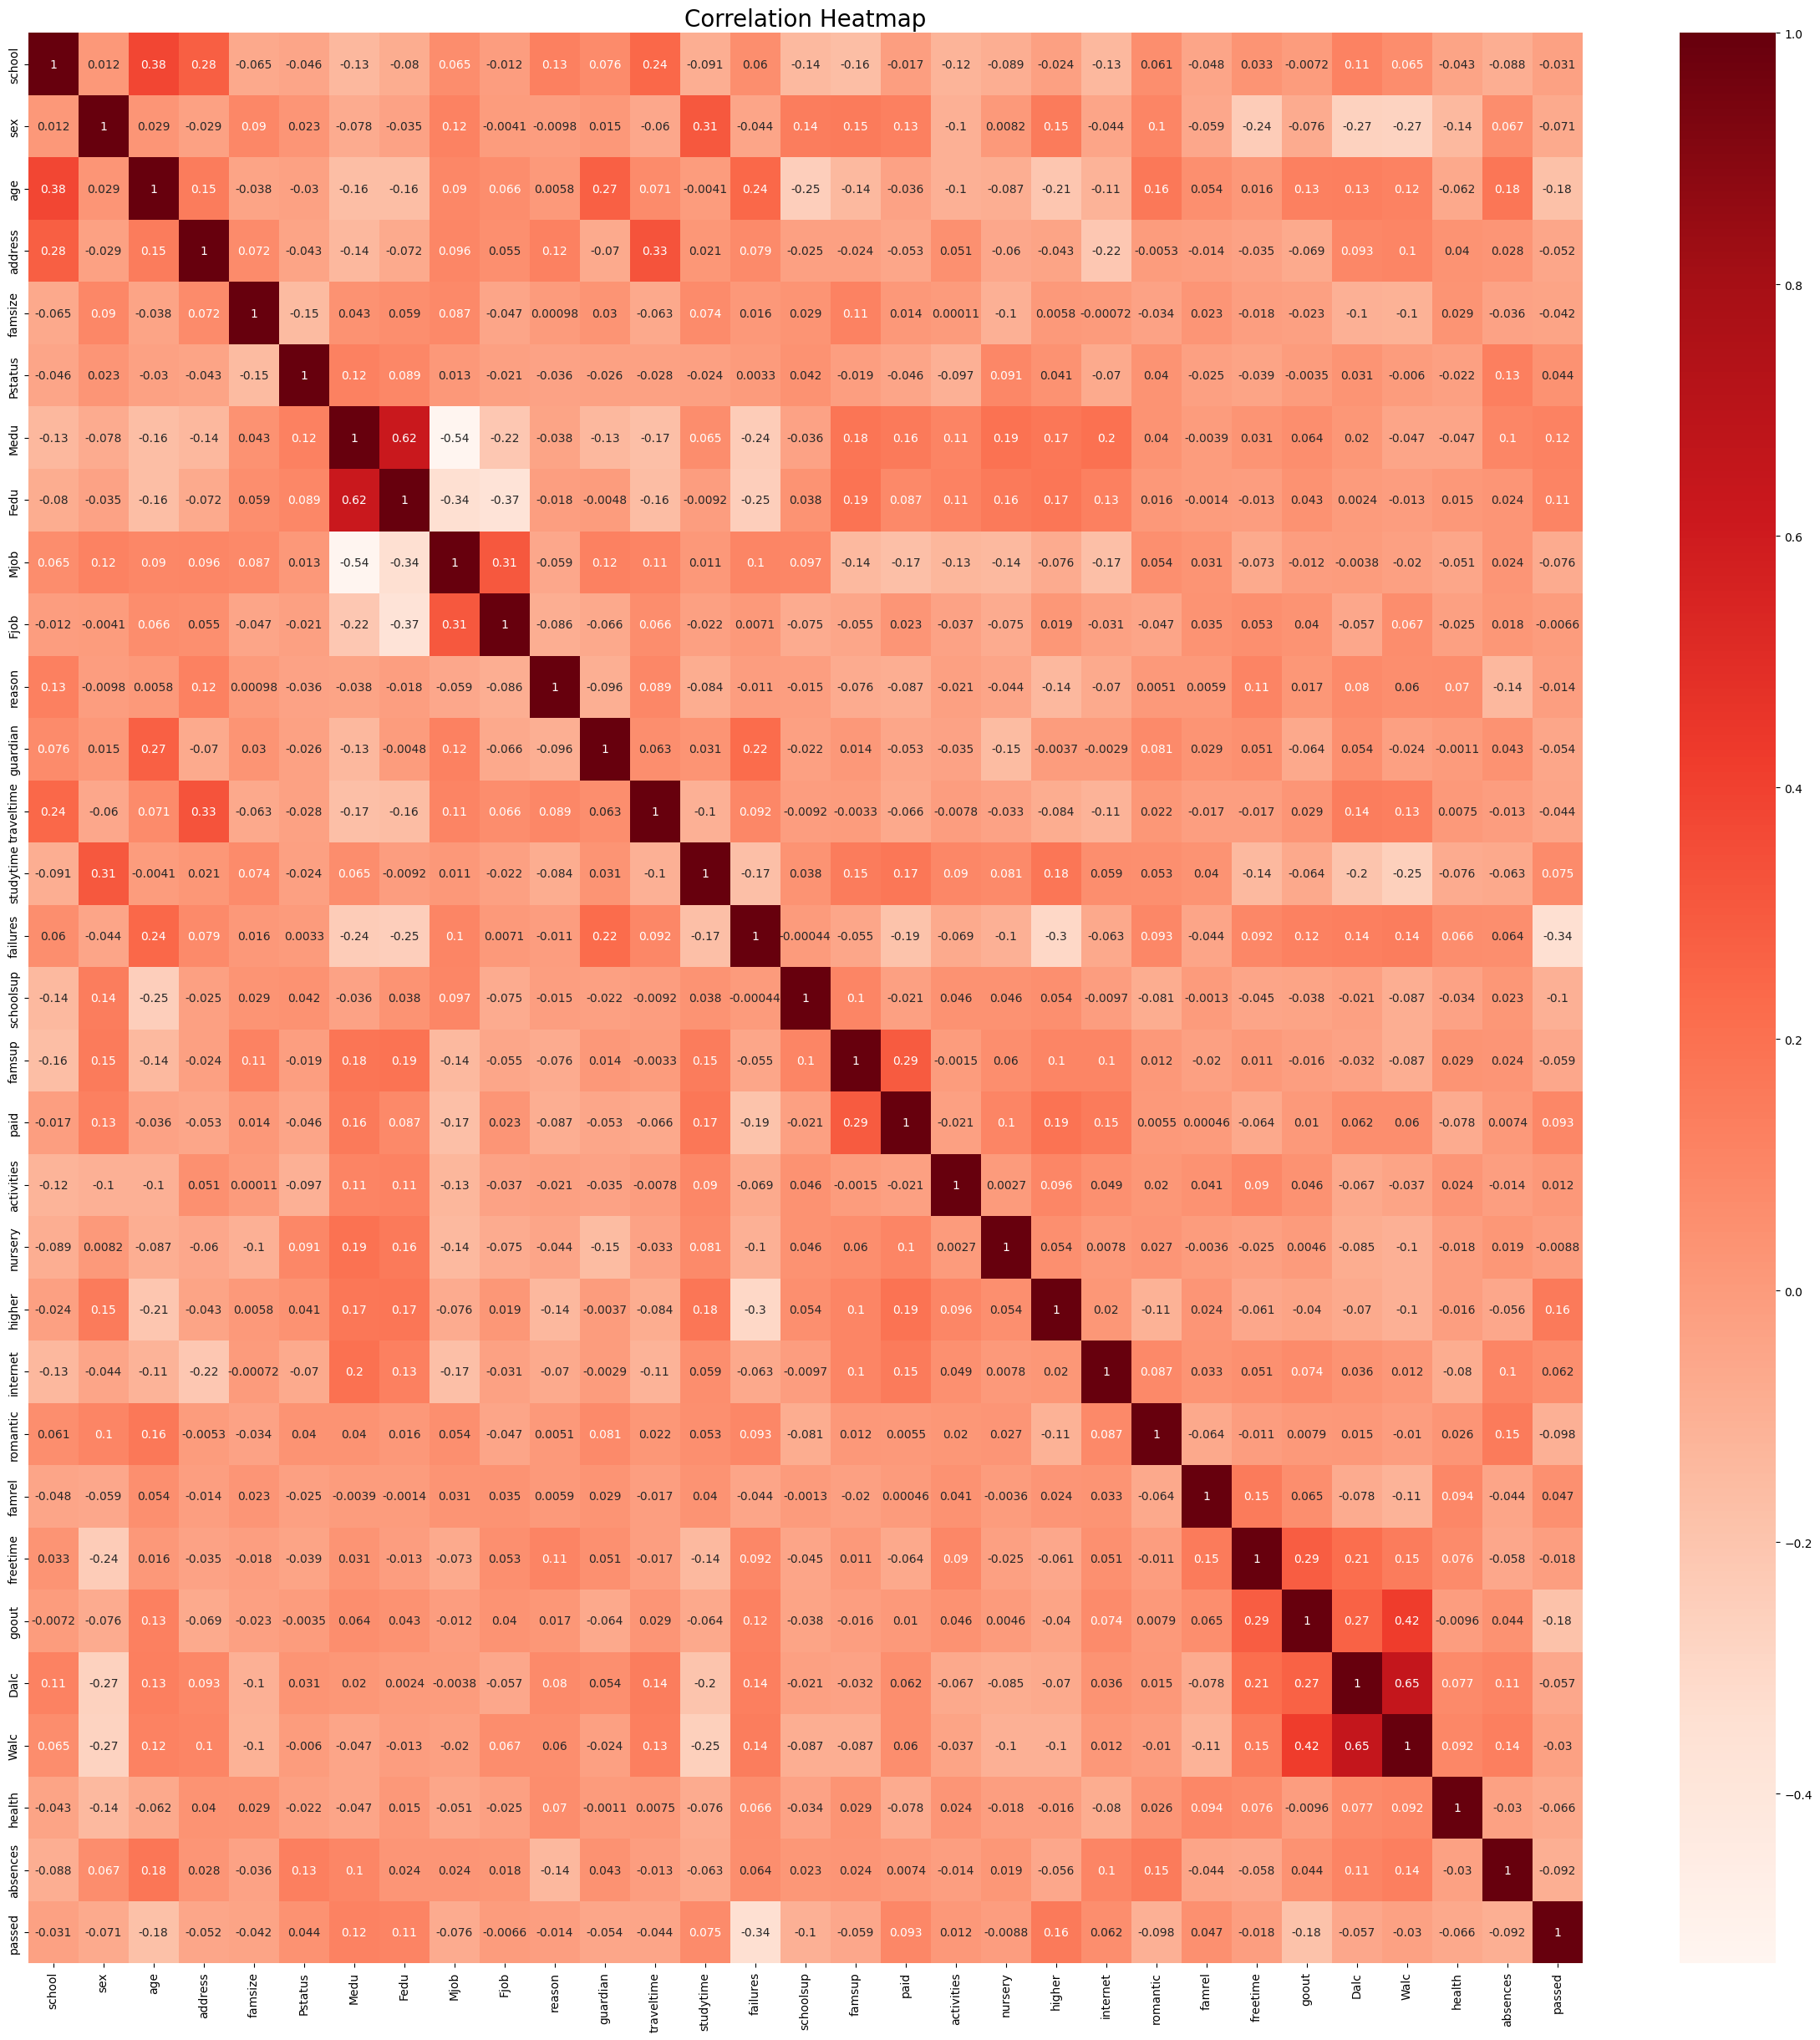

In [13]:
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap="Reds")
plt.title('Correlation Heatmap', fontsize=20)

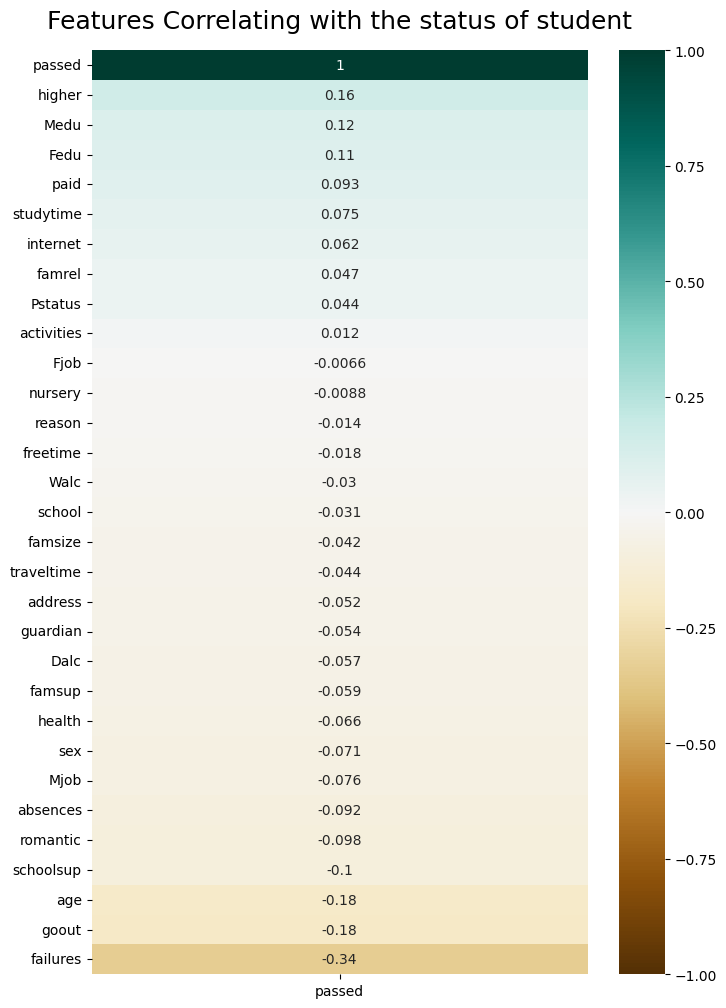

In [14]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['passed']].sort_values(by='passed', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the status of student', fontdict={'fontsize':18}, pad=16);

In [15]:
df["goout"].unique()

array([0.75, 0.5 , 0.25, 0.  , 1.  ])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Support Vector Machine

In [17]:
def showResults(accuracy, trainingTime, y_pred,model):
    
    print('------------------------------------------------Results :',model,'-------------------------------------------------')
    confusionMatrix = confusion_matrix(y_test, y_pred)
    print('\n The ROC curve is :\n')
    fig, _ = plt.subplots()
    fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=model)
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.legend()
    fig.suptitle('ROC curve: '+str(model))
    plt.show()
    
    print('----------------------------------------------')
    print('The model  accuracy:', round(accuracy),'%')
    print('----------------------------------------------')
    print('The training time is: ',trainingTime)
    print('----------------------------------------------')
    print('The f1 score is :',round(100*f1_score(y_test, y_pred, average='macro'))/100)
    print('----------------------------------------------')
    print('The roc_auc_score is :',round(100*roc_auc_score(y_test, y_pred))/100)
    print('----------------------------------------------')
    print('The confusion matrix is :\n')
    ax = plt.axes()
    sns.heatmap(confusionMatrix,annot=True)


# Optimal C 
def optimal_C_value():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    minError = float('Inf')
    optimal_C = float('Inf')

    for c in Ci:
        clf = SVC(C=c,kernel='linear')
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        error = np.mean(np.double(predictions != y_val))
        if error < minError:
            minError = error
            optimal_C = c
    return optimal_C


# Optimal C and the degree of the polynomial
def optimal_C_d_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Di = np.array(( 2, 5, 10, 15, 20, 25, 30))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_d = float('Inf')

    for d in Di:
        for c in Ci:
            clf = SVC(C=c,kernel='poly', degree=d)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_d = d
    return optimal_C,optimal_d


# Optimal C and gamma
def optimal_C_gamma_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Gi = np.array(( 0.000001,0.00001,0.01,1,2,3,5,20,70,100,500,1000))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_g = float('Inf')

    for g in Gi:
        for c in Ci:
            clf = SVC(C=c,kernel='rbf', gamma=g)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_g = g
    return optimal_C,optimal_g


# ------------------------------------------------------------------------------------------------------------------------------
# Compare the three kernels


def compare_kernels():
    X_train1,X_val1,X_test1,y_train1,y_val1,y_test1 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
    X_train2,X_val2,X_test2,y_train2,y_val2,y_test2 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)
    X_train3,X_val3,X_test3,y_train3,y_val3,y_test3 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)
    print('------------------------------------------------ Comparison -----------------------------------------------------')
    print('\n')
    f11 = "{:.2f}".format(f1_score(y_test1, y_linear, average='macro'))
    f22 = "{:.2f}".format(f1_score(y_test2, y_poly, average='macro'))
    f33 = "{:.2f}".format(f1_score(y_test3, y_gauss, average='macro'))
    roc1 = "{:.2f}".format(roc_auc_score(y_test1, y_linear))
    roc2 = "{:.2f}".format(roc_auc_score(y_test2, y_poly))
    roc3 = "{:.2f}".format(roc_auc_score(y_test3, y_gauss))
    a1,a2 = confusion_matrix(y_test1, y_linear)[0],confusion_matrix(y_test1, y_linear)[1]
    b1,b2 = confusion_matrix(y_test2, y_poly)[0],confusion_matrix(y_test2, y_poly)[1]
    c1,c2 = confusion_matrix(y_test3, y_gauss)[0],confusion_matrix(y_test3, y_gauss)[1]
    data_rows = [('training time',time1, time2, time3),
                 ('','','',''),
                  ('accuracy %',linear_accuracy, poly_accuracy, gauss_accuracy),
                 ('','','',''),
                 ('confusion matrix',a1, b1, c1),
                ('',a2,b2,c2),
                 ('','','',''),
                ('f1 score',f11,f22,f33),
                 ('','','',''),
                ('roc_auc_score',roc1,roc2,roc3)]
    t = Table(rows=data_rows, names=('metric','Linear kernel', 'polynomial kernel', 'gaussian kernel'))
    print(t)
    print('\n\n')
    print('The Roc curves :\n')
    y_pred1 = y_linear
    y_pred2 = y_poly
    y_pred3 = y_gauss
    fig, _ = plt.subplots()
    fig.suptitle('Comparison of three ROC curves')
    fpr,tpr,thresholds=roc_curve(y_test1,y_pred1)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Linear kernel :'+str(roc1))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_curve(y_test2,y_pred2)
    plt.plot(fpr,tpr,label='Polynomial kernel :'+str(roc2))
    fpr,tpr,thresholds=roc_curve(y_test3,y_pred3)
    plt.plot(fpr,tpr,label='Gaussian kernel :'+str(roc3))
    plt.legend()
    plt.show()
    

# ------------------------------------------------------------------------------------------------------------------------------
# Print results of the choosen kernel

def best_kernel(kernel):
    X_train1,X_val1,X_test1,y_train1,y_val1,y_test1 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
    X_train2,X_val2,X_test2,y_train2,y_val2,y_test2 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)
    X_train3,X_val3,X_test3,y_train3,y_val3,y_test3 = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)
    
    time = 0
    f1 = 0
    accuracy = 0
    rc = 0
    y = 0
    if kernel == 'linear kernel':
        time = time1
        f1 = "{:.2f}".format(f1_score(y_test1, y_linear, average='macro'))
        accuracy = round(100*linear_accuracy)/100
        rc = round(100*roc_auc_score(y_test1, y_linear))/100
        y_test = y_test1
        y = y_linear
    elif kernel == 'polynomial kernel':
        time = time2
        f1 = "{:.2f}".format(f1_score(y_test2, y_poly, average='macro'))
        accuracy = round(100*poly_accuracy)/100
        rc = round(100*roc_auc_score(y_test2, y_poly))/100
        y_test = y_test2
        y = y_poly
    else :
        time = time3
        f1 = "{:.2f}".format(f1_score(y_test3, y_gauss, average='macro'))
        accuracy = round(100*gauss_accuracy)/100
        rc = round(100*roc_auc_score(y_test3, y_gauss))/100
        y_test = y_test3
        y = y_gauss 
        
    # used for comparing two classfiers(logistic regression and svm)
    yt_svm,yp_svm = y_test, y
    
    print('The choosen kernel :',kernel)
    print('the training :',time)
    print('the accuracy :',round(accuracy),'%')
    print('the f1 score :',f1)
    print('The roc_auc_score is :',rc)
    print('----------------------------------------\nThe ROC curve :')
    fig, _ = plt.subplots()
    fpr,tpr,thresholds=roc_curve(y_test,y)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=kernel+': '+str(rc))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.legend()
    plt.show()
    confusionMatrix = confusion_matrix(y_test, y)
    print('----------------------------------------\nThe confusion matrix is  :')
    ax = plt.axes()
    sns.heatmap(confusionMatrix,annot=True)
    ax.set_title('Confusion matrix of SVM '+str(kernel))
    return yt_svm,yp_svm
    
 



def factors(array, K, max_or_min, df):
    
    n = array.shape[1]
    array = array.reshape(n,1)
    my_list = array.tolist()
    
    if max_or_min == 'max':
        temp = sorted(my_list)[-K:]
        res = [] 
        for ele in temp: 
            res.append(my_list.index(ele))
        return(get_factors(res, df))
    
    
    elif max_or_min == 'min':
        temp = sorted(my_list, reverse=True)[-K:]
        temp = temp = np.array(temp).reshape(K,1)
        res = []
        for ele in temp:
            if ele<0:
                res.append(my_list.index(ele))
        return(get_factors(res, df))
    

    else:
        return
    

def get_factors(index, df):
    f = []
    for i in index:
        f.append(df.columns[i])
    return f
    

 
columns_name = {'famsize': 'family size', 'Pstatus': "parent's cohabitation status ", 'Medu': "mother's education",
                'Fedu': "father's education", 'Mjob': "mother's job", 'Fjob': "father's job", 
                'reason': 'reason to choose this school ','schoolsup': 'extra educational support', 'famsup': 'family educational support',
                'paid': 'extra paid classes within the course subject', 'higher': 'wants to take higher education',
                'romantic': 'with a romantic relationship ', 'famrel': 'quality of family relationships', 'goout': 'going out with friends',
                'Dalc': 'workday alcohol consumption', 'Walc': 'weekend alcohol consumption'}        


def column_to_string(fcts,max_or_min):
    
    if max_or_min == 'max':
        print('-----------------------------------------------------------------------------------')
        print('Factors helping students succeed :')
    else:
        print('-----------------------------------------------------------------------------------')
        print('-----------------------------------------------------------------------------------')
        print('Factors leading students to failure')
        
    for fct in fcts:
        if fct in columns_name:
            print(columns_name[fct])
        else:
            print(fct)
    

def split(df,rest_size,test_size,randomState):
    data = df.to_numpy()
    n = data.shape[1]
    x = data[:,0:n-1]
    y = data[:,n-1]
    if(randomState):
        X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=rest_size,random_state=randomState)
        X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=test_size,random_state=randomState)
    else:
        X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=rest_size,random_state=0)
        X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=test_size,random_state=0)
    
    return X_train,X_val,X_test,y_train,y_val,y_test

## 1.Linear Kernel

------------------------------------------------Results : SVM linear kernel -------------------------------------------------

 The ROC curve is :



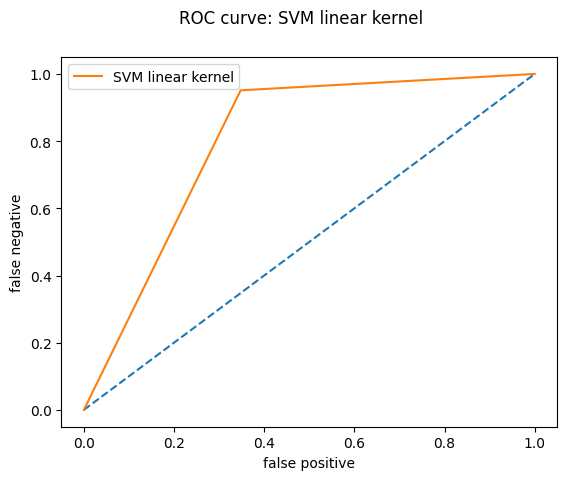

----------------------------------------------
The model  accuracy: 84 %
----------------------------------------------
The training time is:  24ms
----------------------------------------------
The f1 score is : 0.82
----------------------------------------------
The roc_auc_score is : 0.8
----------------------------------------------
The confusion matrix is :



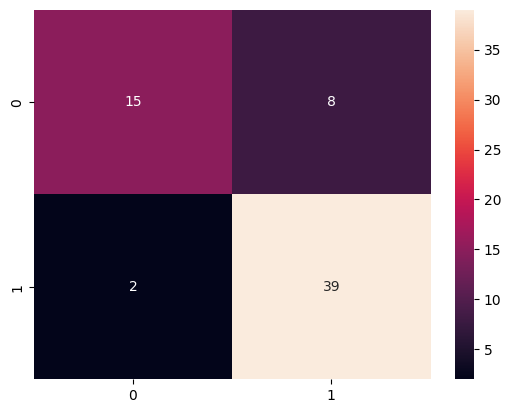

In [18]:
optimal_split_state1 = 0
maxAccuracy = 0
maxF1 = 0


max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------Hyperparameters tunning starts----------------------------------------\n\n')

for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+' Current f1 '+str(maxF1), end="\r")
   
    split_state = np.random.randint(1,1000000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)
    optimal_C = optimal_C_value()


    linear_clf = SVC(C=optimal_C,kernel='linear')

    tic = time()
    linear_clf.fit(X_train, y_train)
    toc = time()
    time1 = str(round(1000*(toc-tic))) + "ms"
    y_linear = linear_clf.predict(X_test)
    linear_f1 = f1_score(y_test, y_linear, average='macro')
    linear_accuracy = accuracy_score(y_test, y_linear)*100
    if linear_accuracy>maxAccuracy and linear_f1>maxF1:
        maxAccuracy = linear_accuracy
        maxF1 = linear_f1
        optimal_split_state1 = split_state
    if maxAccuracy>86 and maxF1>80:
        break;
        
optimal_split_state1 = 388628375
X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state1)
optimal_C = optimal_C_value()


linear_clf = SVC(C=optimal_C,kernel='linear')

tic = time()
linear_clf.fit(X_train, y_train)
toc = time()
time1 = str(round(1000*(toc-tic))) + "ms"
y_linear = linear_clf.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_linear)*100
if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')

showResults(linear_accuracy, time1, y_linear,'SVM linear kernel')

## 2.Polynomial Kernel

------------------------------------------------Results : SVM polynomial kernel -------------------------------------------------

 The ROC curve is :



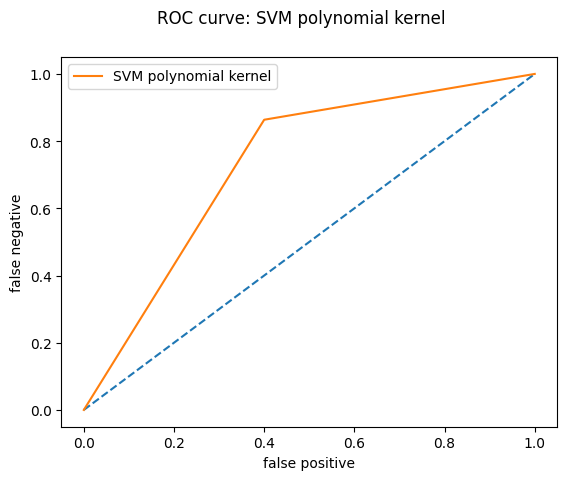

----------------------------------------------
The model  accuracy: 78 %
----------------------------------------------
The training time is:  16ms
----------------------------------------------
The f1 score is : 0.74
----------------------------------------------
The roc_auc_score is : 0.73
----------------------------------------------
The confusion matrix is :



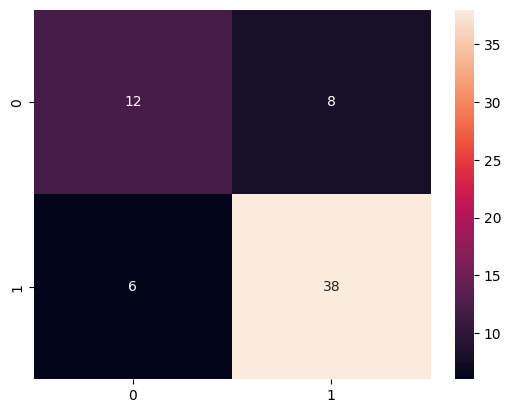

In [19]:
optimal_split_state2 = 0
maxAccuracy = 0
maxF1 = 0



max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------Hyperparameters tunning starts----------------------------------------\n\n')
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+', Current f1 '+str(maxF1), end="\r")
    
    split_state = np.random.randint(1,100000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)

    optimal_C, optimal_d = optimal_C_d_values()
    
    poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

    poly_clf.fit(X_train, y_train)
    y_poly = poly_clf.predict(X_test)
    poly_f1 = f1_score(y_test, y_poly, average='macro')
    poly_accuracy = accuracy_score(y_test, y_poly)*100
    
    if poly_accuracy>maxAccuracy and poly_f1>maxF1:
        maxAccuracy = poly_accuracy
        maxF1 = poly_f1
        optimal_split_state2 = split_state

optimal_split_state2 = 7070621

X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state2)

optimal_C, optimal_d = optimal_C_d_values()


poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

tic = time()
poly_clf.fit(X_train, y_train)
toc = time()
time2 = str(round(1000*(toc-tic))) + "ms"
y_poly = poly_clf.predict(X_test)
poly_accuracy = accuracy_score(y_test, y_poly)*100
if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')

showResults(poly_accuracy, time2, y_poly,'SVM polynomial kernel')

## 3.Gaussian Kernel

------------------------------------------------Results : SVM gaussian kernel -------------------------------------------------

 The ROC curve is :



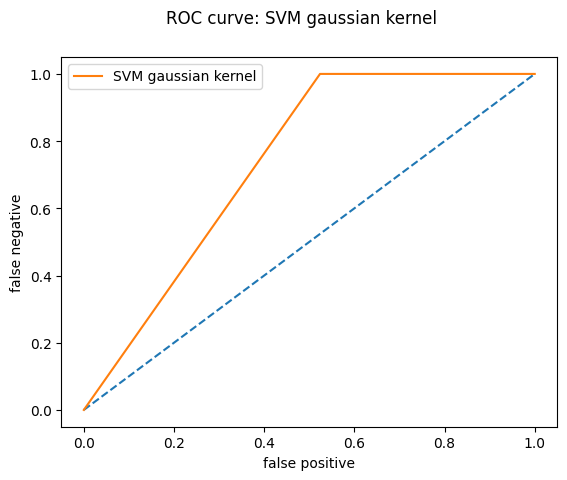

----------------------------------------------
The model  accuracy: 83 %
----------------------------------------------
The training time is:  0ms
----------------------------------------------
The f1 score is : 0.77
----------------------------------------------
The roc_auc_score is : 0.74
----------------------------------------------
The confusion matrix is :



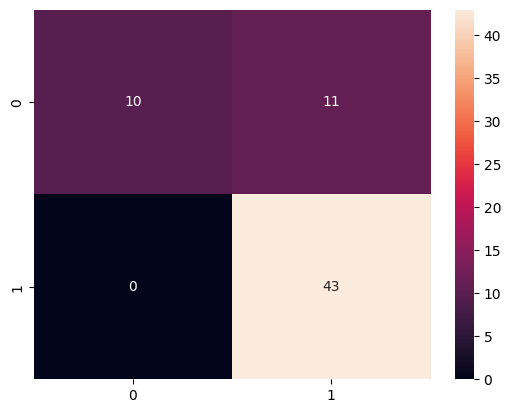

In [20]:
optimal_split_state3 = 0
maxAccuracy = 0
maxF1 = 0


max_iteration = 0
if max_iteration != 0:
    print ('----------------------------------------------Hyperparameters tunning starts'\
          '--------------------------------------------\n\n')
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+', Current f1 '+str(maxF1), end="\r")
    
    split_state = np.random.randint(1,100000000)-1
    X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=split_state)

    optimal_C, optimal_gamma = optimal_C_gamma_values()
    
    gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

     
    gauss_clf.fit(X_train, y_train)
    y_gauss = gauss_clf.predict(X_test)
    gauss_f1 = f1_score(y_test, y_gauss, average='macro')
    gauss_accuracy = accuracy_score(y_test, y_gauss)*100
    
    if gauss_accuracy>maxAccuracy and gauss_f1>maxF1:
        maxAccuracy = gauss_accuracy
        maxF1 = gauss_f1
        optimal_split_state3 = split_state

optimal_split_state3 = 93895097

X_train,X_val,X_test,y_train,y_val,y_test = split(df,rest_size=0.4,test_size=0.4,randomState=optimal_split_state3)

optimal_C, optimal_gamma = optimal_C_gamma_values()


gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

tic = time()
gauss_clf.fit(X_train, y_train)
toc = time()
time3 = str(round(1000*(toc-tic))) + "ms"
y_gauss = gauss_clf.predict(X_test)
gauss_accuracy = (accuracy_score(y_test, y_gauss)*100)

if max_iteration != 0:
    print('\n\n\n                            ---------------------------process ended'\
         '------------------------------------                            \n\n\n')
                                                                
showResults(gauss_accuracy, time3, y_gauss,'SVM gaussian kernel')

## Comparison between 3 Kernels

------------------------------------------------ Comparison -----------------------------------------------------


     metric      Linear kernel polynomial kernel gaussian kernel
---------------- ------------- ----------------- ---------------
   training time          24ms              16ms             0ms
                                                                
      accuracy %        84.375            78.125         82.8125
                                                                
confusion matrix       [15  8]           [12  8]         [10 11]
                       [ 2 39]           [ 6 38]         [ 0 43]
                                                                
        f1 score          0.82              0.74            0.77
                                                                
   roc_auc_score          0.80              0.73            0.74



The Roc curves :



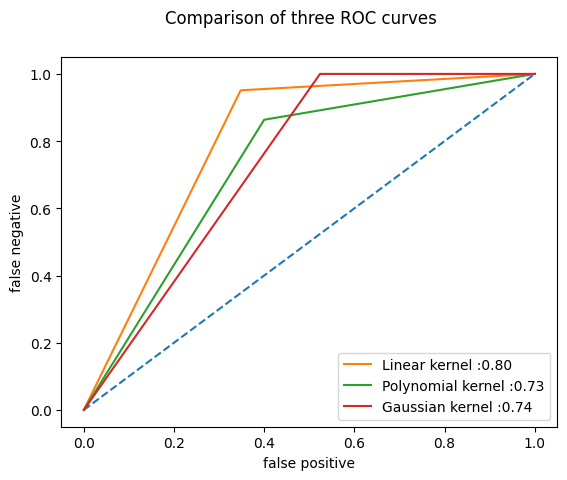

In [21]:
compare_kernels()

The choosen kernel : linear kernel
the training : 24ms
the accuracy : 84 %
the f1 score : 0.82
The roc_auc_score is : 0.8
----------------------------------------
The ROC curve :


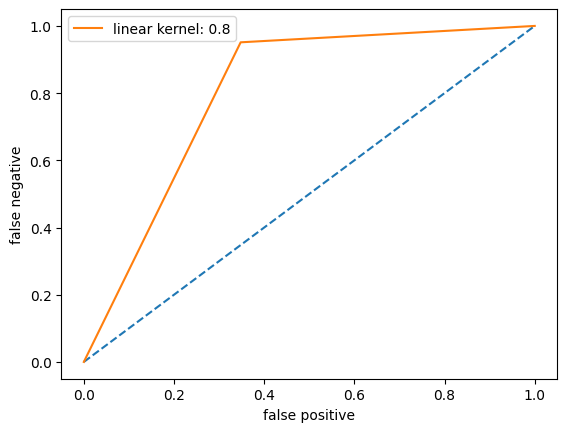

----------------------------------------
The confusion matrix is  :


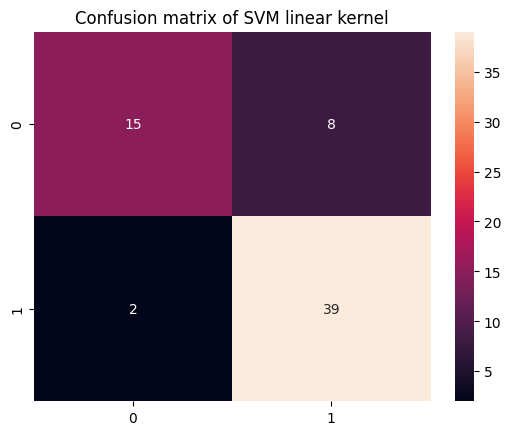

In [22]:
yt_svm,yp_svm = best_kernel('linear kernel')

In [23]:
# Get svm parameters
coefs = linear_clf.coef_

# factors helping students to succeed
column_to_string(factors(coefs, 5, 'max', df),'max')

# factors leading students to failure
column_to_string(factors(coefs, 5, 'min', df), 'min')

-----------------------------------------------------------------------------------
Factors helping students succeed :
father's education
guardian
wants to take higher education
studytime
father's job
-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------
Factors leading students to failure
age
health
going out with friends
absences
failures


## Logistic Regression

In [24]:
data = df.to_numpy()
n = data.shape[1]
x = data[:,0:n-1]
y = data[:,n-1]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [25]:
logisticRegr = LogisticRegression(C=1)

In [26]:
logisticRegr.fit(x_train,y_train)

LogisticRegression(C=1)

In [27]:
y_pred=logisticRegr.predict(x_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.])

In [28]:
Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('#Accuracy test is: ',Sctest)
print('#Accuracy train is: ',Sctrain)


f1 = f1_score(y_test, y_pred, average='macro')

print('\n#f1 score is: ',f1)

#Accuracy test is:  0.6386554621848739
#Accuracy train is:  0.7463768115942029

#f1 score is:  0.5533734834598935


In [29]:
Sctest=logisticRegr.score(x_test,y_test)
Sctrain=logisticRegr.score(x_train,y_train)

print('Accuracy test is: ',Sctest)
print('Accuracy train is: ',Sctrain)

Accuracy test is:  0.6386554621848739
Accuracy train is:  0.7463768115942029


In [30]:
confusion_matrix(y_test, y_pred)

array([[12, 38],
       [ 5, 64]], dtype=int64)

<AxesSubplot: >

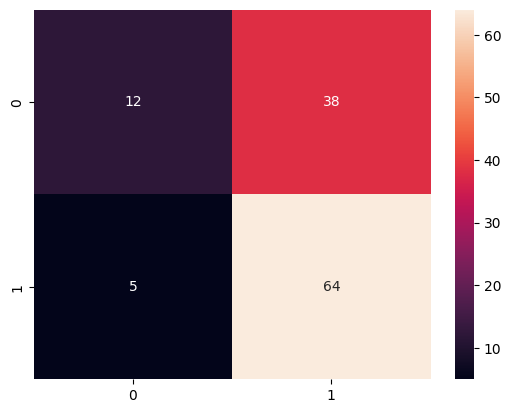

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.24      0.36        50
         1.0       0.63      0.93      0.75        69

    accuracy                           0.64       119
   macro avg       0.67      0.58      0.55       119
weighted avg       0.66      0.64      0.58       119



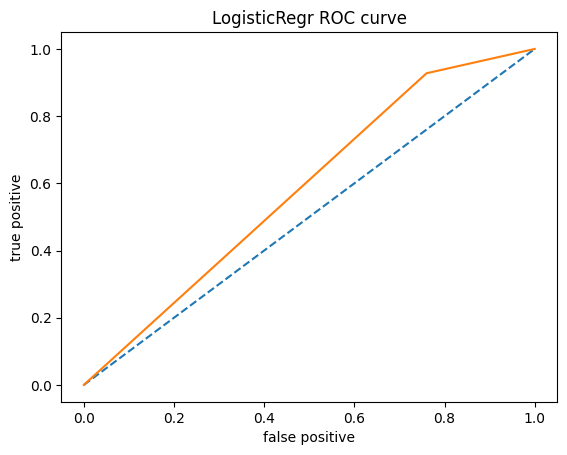

In [33]:
fpositive, tpositive, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositive,tpositive, label='LogisticRegr')
plt.xlabel('false positive')
plt.ylabel('true positive')
plt.title('LogisticRegr ROC curve')
p=plt.show()




*Accuracy is: 80.67226890756302
*f1 score is:  0.7408389357068459


 *the ROC curve: 


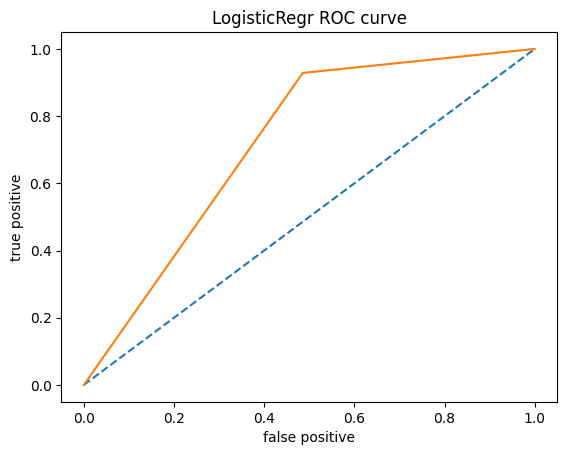

 *the confusion matrix 


<AxesSubplot: >

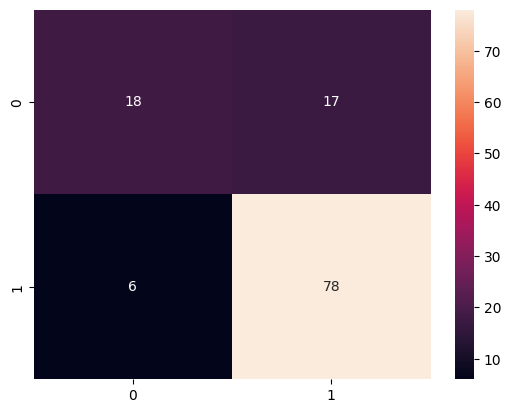

In [34]:
max_iteration = 0
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
import random
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=split_state)
    logisticRegr = LogisticRegression(C=1)
    logisticRegr.fit(x_train,y_train)
    y_pred=logisticRegr.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
   
optimal_state = 85491961
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=optimal_state)
logisticRegr = LogisticRegression(C=1)
logisticRegr.fit(x_train,y_train)
y_pred=logisticRegr.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

yt_lg,yp_lg = y_test,y_pred
#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

fpositive, tpositive, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'--')
plt.plot(fpositive,tpositive, label='LogisticRegr')
plt.xlabel('false positive')
plt.ylabel('true positive')
plt.title('LogisticRegr ROC curve')
p=plt.show()


#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.51      0.61        35
         1.0       0.82      0.93      0.87        84

    accuracy                           0.81       119
   macro avg       0.79      0.72      0.74       119
weighted avg       0.80      0.81      0.79       119



## Comparison between 2 algorithms

In [36]:
def compare_lg_svm(yt_lg,yp_lg,yt_svm,yp_svm):
    #F1 score
    f1_lg = round(f1_score(yt_lg, yp_lg, average='macro')*100)
    f1_svm = round(f1_score(yt_svm, yp_svm, average='macro')*100)
    
    #Accuracy score
    acc_lg = round(accuracy_score(yt_lg, yp_lg)*100)
    acc_svm = round(accuracy_score(yt_svm, yp_svm)*100)
    
    #Confusion matrix
    conf_lg = confusion_matrix(yt_lg, yp_lg)
    conf_svm = confusion_matrix(yt_svm, yp_svm)
    
    #ROC score
    roc_c_lg = round(roc_auc_score(yt_lg, yp_lg)*100)
    roc_c_svm = round(roc_auc_score(yt_svm, yp_svm)*100)
    
    #ROC curve thresholds
    roc_lg = roc_curve(yt_lg,yp_lg)
    roc_svm = roc_curve(yt_svm,yp_svm)
    
    # Table of metrics
    print('-----------------------------Table of metrics--------------------------------------\n\n')
    data_rows = [('f1 score',f1_lg,f1_svm),
                 ('','','',''),
                  ('accuracy %',acc_lg,acc_svm),
                 ('','','',''),
                 ('confusion matrix',conf_lg[0], conf_svm[0]),
                ('',conf_lg[1], conf_svm[1]),
                 ('','','',''),
                ('ROC score',roc_c_lg,roc_c_svm)]
    t = Table(rows=data_rows, names=('metric','Logistic regression', 'SVM'))
    print(t)
    
    #Plot ROC curve
    print('\n\n-----------------------------ROC curves--------------------------------------\n\n')
    fig, _ = plt.subplots()
    fig.suptitle('Comparison of two ROC curves')
    fpr,tpr,thresholds=roc_lg
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Logistic regression :'+str(roc_c_lg))
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_svm
    plt.plot(fpr,tpr,label='SVM :'+str(roc_c_svm))
    plt.legend()
    plt.show()
    
    
    # Maximum metrics
    print('-----------------------------Max of metrics--------------------------------------\n\n')
    data_rows = [('max f1 score',algo_with_max_metric(f1_lg,f1_svm)),
                 ('','','',''),
                  ('max accuracy %',algo_with_max_metric(acc_lg,acc_svm)),
                 ('','','',''),
                ('max ROC score',algo_with_max_metric(roc_c_lg,roc_c_svm))]
    t = Table(rows=data_rows, names=('metric','Learning algorithm winnig'))
    print(t)
    
def algo_with_max_metric(a,b):
    max_metric = max(a,b)
    if max_metric == a:
        return 'Logistic regression'
    else:
        return 'SVM'

-----------------------------Table of metrics--------------------------------------


     metric      Logistic regression   SVM  
---------------- ------------------- -------
        f1 score                  74      82
                                            
      accuracy %                  81      84
                                            
confusion matrix             [18 17] [15  8]
                             [ 6 78] [ 2 39]
                                            
       ROC score                  72      80


-----------------------------ROC curves--------------------------------------




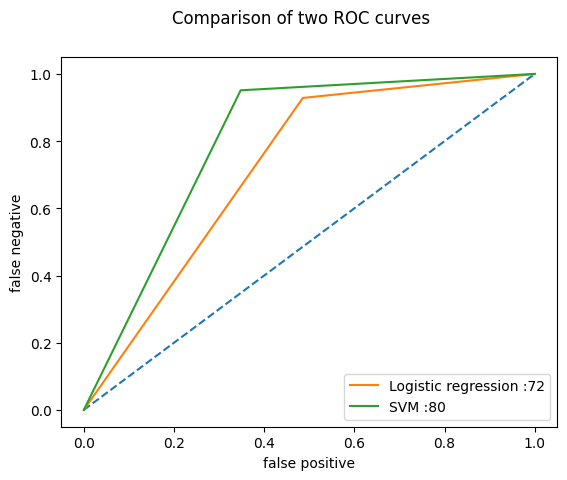

-----------------------------Max of metrics--------------------------------------


    metric     Learning algorithm winnig
-------------- -------------------------
  max f1 score                       SVM
                                        
max accuracy %                       SVM
                                        
 max ROC score                       SVM


In [37]:
compare_lg_svm(yt_lg,yp_lg,yt_svm,yp_svm)